In [ ]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
#try:
import google.colab
from google.colab import files  
COLAB = True
#except:
COLAB = False

In [ ]:
device = 'cpu'

In [ ]:
verbose=True

In [ ]:
train_dataset = datasets.FashionMNIST(  
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.FashionMNIST(   
   root="data",
   train=False,
   download=True,
   transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()    
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) 
        return image,label

In [ ]:
#Creamos un objeto Dataset personalizado a partir del Dataset Fashion MNIST
train_dataset = CustomImageDataset(train_dataset)
test_dataset = CustomImageDataset(test_dataset)

len(train_dataset),len(test_dataset)

(60000, 10000)

Defino la red neuronal con autoencoder

In [ ]:
# Definimos la red autoencoder

class Autoencoder(nn.Module):
    
    def __init__(self,n,p=0.1): 
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, n),
            nn.ReLU(),
            nn.Dropout(p),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(n, 28*28),
            nn.Sigmoid()
        )        

    def forward(self,x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

In [ ]:
#Creamos el autoencoder
model = Autoencoder(n=64,p=0.1)
print (model)


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=20):  
    # Calculamos cosas utiles que necesitamos
    num_samples = len(dataloader.dataset) 
    model.train()
    # Pasamos el modelo la GPU si está disponible.        
    model = model.to(device)    
    # Iteramos sobre lotes (batchs)
    for batch,(X,y) in enumerate(dataloader):
        # Pasamos los tensores a la GPU si está disponible.
        X = X.to(device)
        y = y.to(device)      
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()              
        optimizer.step()
        # Imprimimos el progreso cada 100 batchs
        if verbose and batch % verbose_each*len(X) == 0:
            loss   = loss.item()
            sample = batch*len(X) # Número de batch * número de muestras en cada batch
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{sample:>5d}/{num_samples:>5d}]")
            model.eval()
# De manera similar, definimos la función de validación y testeo
def test_loop(dataloader,model,loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avrg_loss    = 0
    
   
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device) 
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
         
            avrg_loss += loss_fn(pred,y).item()
            

    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
   
    return avrg_loss

In [ ]:
 Entrenamiento
# Definimos los hiperparámetros del entrenamiento
learning_rate = 1e-1   
num_epochs = 200
batch_size = 1000    

#Función de pérdida
loss_fn = nn.MSELoss()

#Creamos DataFrame de pandas para ir almacenando los valores calculados
df = pd.DataFrame()
# Creamos data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#Tamaño n de la capa intermedia
size = [64,128,256,512]
for n in size:
    #Creamos el modelo y el optimizador
    model=Autoencoder(n)

    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)   

    #Entrenamos el modelo y calculamos las curvas
    for epoch in range(num_epochs):
        train_loop(train_dataloader,model,loss_fn,optimizer) 
        train_loss = test_loop(train_dataloader,model,loss_fn) 
        test_loss = test_loop(test_dataloader,model,loss_fn)
        print(f"n={n} epoch={epoch} train_loss{train_loss} test_loss{test_loss}")
        df = df.append({"n":n,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "test_loss":test_loss}
                        ,ignore_index=True)
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

batch=0 loss=0.172926  muestras-procesadas:[    0/60000]
batch=20 loss=0.171006  muestras-procesadas:[20000/60000]
batch=40 loss=0.170157  muestras-procesadas:[40000/60000]
n=64 epoch=0 train_loss0.1697816180686156 test_loss0.16902753859758377
batch=0 loss=0.171219  muestras-procesadas:[    0/60000]
batch=20 loss=0.169537  muestras-procesadas:[20000/60000]
batch=40 loss=0.168757  muestras-procesadas:[40000/60000]
n=64 epoch=1 train_loss0.16837604095538458 test_loss0.16762538254261017
batch=0 loss=0.169856  muestras-procesadas:[    0/60000]
batch=20 loss=0.168170  muestras-procesadas:[20000/60000]
batch=40 loss=0.167457  muestras-procesadas:[40000/60000]
n=64 epoch=2 train_loss0.16707597747445108 test_loss0.16632835566997528
batch=0 loss=0.168577  muestras-procesadas:[    0/60000]
batch=20 loss=0.166855  muestras-procesadas:[20000/60000]
batch=40 loss=0.166120  muestras-procesadas:[40000/60000]
n=64 epoch=3 train_loss0.16565549845496813 test_loss0.16491107642650604
batch=0 loss=0.167254

In [ ]:
json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
#json_fname = "simulation-results-"+dt+".json" 
if COLAB:
    files.download(json_fname)

In [ ]:

json_fname 

'simulation-results-2021-12-20-16-09-10.json'

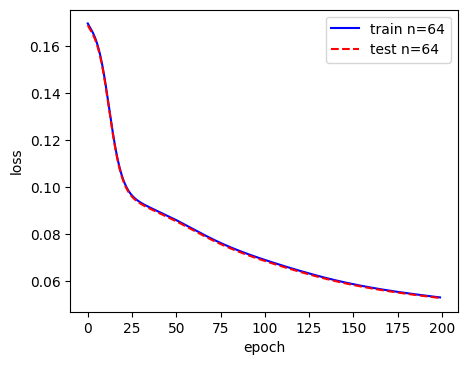

In [ ]:
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams['figure.dpi'] = 100 
plt.xlabel("epoch")
plt.ylabel("loss")

dfn = df[df["n"]==64]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={64}",color='blue')
plt.plot(x,dfn["test_loss"],label= f"test n={64}",color='red',linestyle='--')
plt.legend()
plt.show()

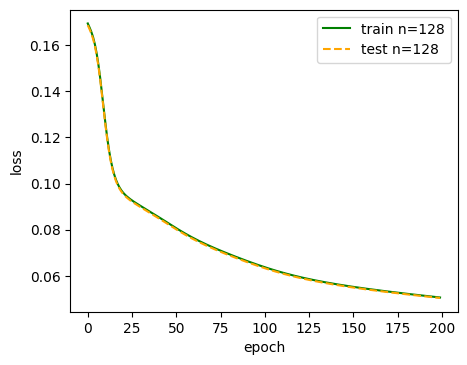

In [ ]:
plt.rcParams["figure.figsize"] = (5,4) 
plt.rcParams['figure.dpi'] = 100 
plt.xlabel("epoch")
plt.ylabel("loss")

dfn = df[df["n"]==128]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={128}",color='green')
plt.plot(x,dfn["test_loss"],label= f"test n={128}",color='orange',linestyle='--')
plt.legend()
plt.show()

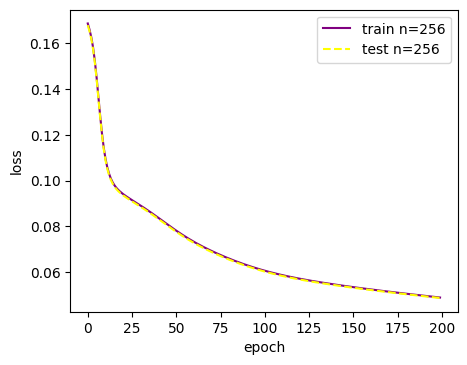

In [ ]:
plt.rcParams["figure.figsize"] = (5,4) 
plt.rcParams['figure.dpi'] = 100 
plt.xlabel("epoch")
plt.ylabel("loss")

dfn = df[df["n"]==256]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={256}",color='purple')
plt.plot(x,dfn["test_loss"],label= f"test n={256}",color='yellow',linestyle='--')
plt.legend()
plt.show()

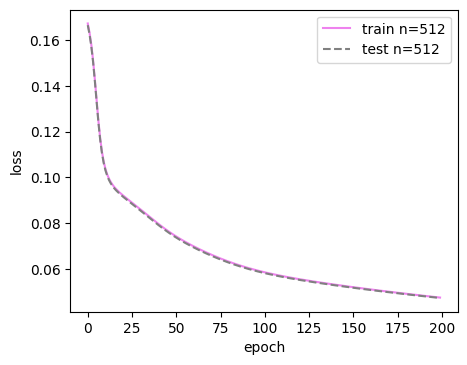

In [ ]:
plt.rcParams["figure.figsize"] = (5,4)
plt.rcParams['figure.dpi'] = 100
plt.xlabel("epoch")
plt.ylabel("loss")

dfn = df[df["n"]==512]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={512}",color='violet')
plt.plot(x,dfn["test_loss"],label= f"test n={512}",color='grey',linestyle='--')
plt.legend()
plt.show()

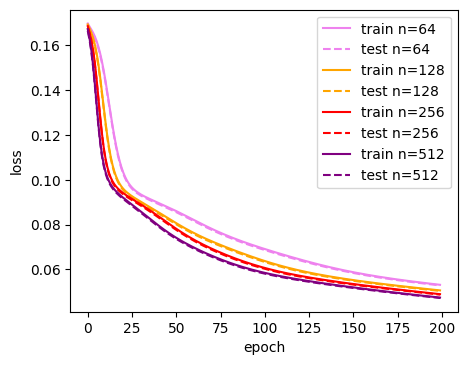

In [ ]:
#GRÁFICO ERROR VS EPOCA
plt.rcParams["figure.figsize"] = (5,4) 
plt.rcParams['figure.dpi'] = 100 
plt.xlabel("epoch")
plt.ylabel("loss")

# GRÁFICO n=64
dfn = df[df["n"]==64]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={64}",color='violet')
plt.plot(x,dfn["test_loss"],label= f"test n={64}",color='violet',linestyle='--')

# GRÁFICO n=128
dfn = df[df["n"]==128]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={128}",color='orange')
plt.plot(x,dfn["test_loss"],label= f"test n={128}",color='orange',linestyle='--')

# GRÁFICO n=256
dfn = df[df["n"]==256]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={256}",color='red')
plt.plot(x,dfn["test_loss"],label= f"test n={256}",color='red',linestyle='--')

# GRÁFICO n=512
dfn = df[df["n"]==512]
x = dfn["epoch"]
plt.plot(x,dfn["train_loss"],label=f"train n={512}",color='purple')
plt.plot(x,dfn["test_loss"],label= f"test n={512}",color='purple',linestyle='--')
plt.legend()
#fig.tight_layout()
plt.show()